Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Test set accuracy: 0.99
K-Fold Cross-Validation Accuracy: 0.99 ± 0.00
Classification Report:
              precision    recall  f1-score   support

       Risky       0.99      1.00      0.99      3994
    Moderate       0.98      0.99      0.99      2713
        Safe       0.97      0.87      0.91       167

    accuracy                           0.99      6874
   macro avg       0.98      0.95      0.97      6874
weighted avg       0.99      0.99      0.99      6874



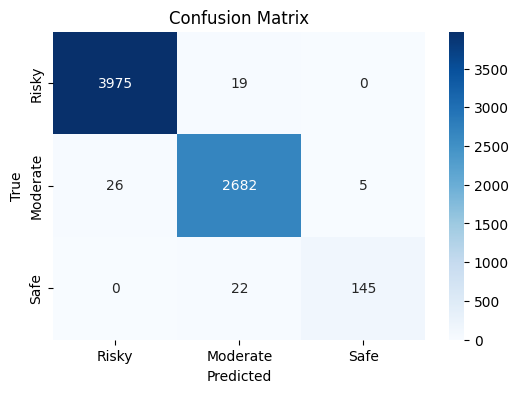

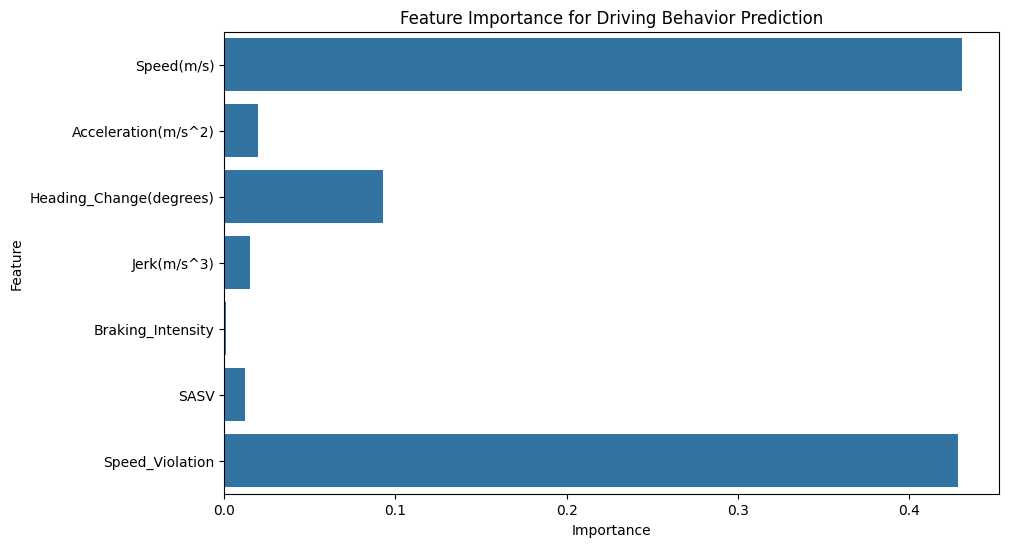

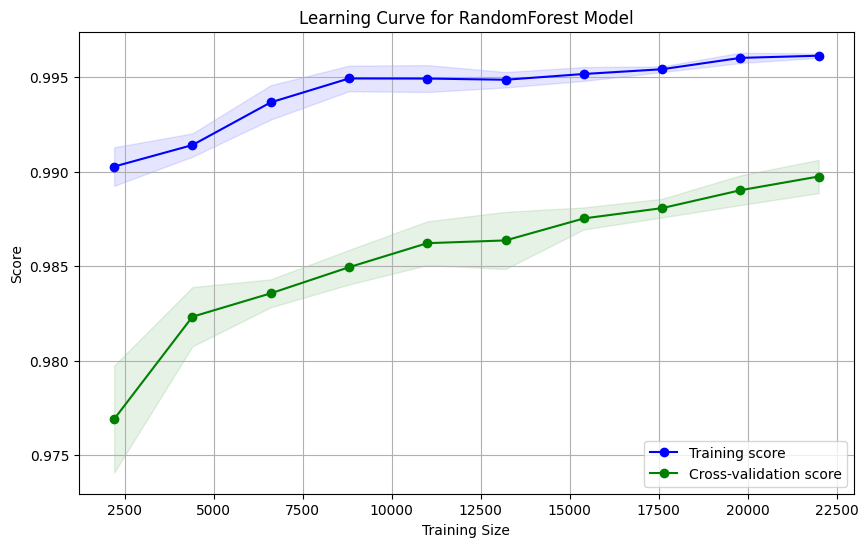

Model saved to ../models\driving_data_model.pkl


In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the preprocessed data
df = pd.read_csv('../data/processed_data.csv')

# Feature Selection: Include relevant features for ML training
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity', 'SASV', 'Speed_Violation']]
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})  # Convert driving categories to numeric labels

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the directory to save the model and scaler
model_directory = '../models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the scaler for future use
scaler_path = os.path.join(model_directory, 'scaler.pkl')
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# RandomizedSearchCV for hyperparameter tuning with reduced parameters
param_dist = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [10, 20, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

# Implement K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Use RandomizedSearchCV for hyperparameter tuning with cross-validation
model = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_dist, 
    n_iter=10,  # Number of parameter settings sampled
    cv=kf,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available cores
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Get the best parameters from the RandomizedSearch
print(f"Best parameters found: {model.best_params_}")

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

# K-Fold Cross-Validation Accuracy
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
cv_accuracy_mean = np.mean(cv_scores)
cv_accuracy_std = np.std(cv_scores)
print(f"K-Fold Cross-Validation Accuracy: {cv_accuracy_mean:.2f} ± {cv_accuracy_std:.2f}")

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance plot
feature_importances = model.best_estimator_.feature_importances_
features = ['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity', 'SASV', 'Speed_Violation']
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance for Driving Behavior Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Learning curve plot
train_sizes, train_scores, test_scores = learning_curve(model.best_estimator_, X_train_scaled, y_train, cv=kf, n_jobs=-1,
                                                        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve for RandomForest Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Save the trained model to a file
model_filename = os.path.join(model_directory, 'driving_data_model.pkl')
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Model saved to {model_filename}")


In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Now use the resampled data to train the model
model.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set (without resampling)
y_pred = model.predict(X_test_scaled)
